#  Прогнозирование заказов такси

Компания «Чётенькое такси» собрала исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки. 

**Цель** - Спрогнозировать количество заказов такси на следующий час.

**Задача** - Построить модель для предсказания заказов такси на следующий час.

Значение метрики **RMSE** на тестовой выборке должно быть не больше 48.

Данные лежат в файле `/datasets/taxi.csv`. Количество заказов находится в столбце `num_orders`.

**План исследования** 
1. Изучение данных 
2. Подготовка и предобработка данных
3. Анализ
4. Обучение
5. Тестирование
6. Вывод

## Изучение данных
### Импорт библиотек

In [1]:
import os
import warnings
from math import sqrt

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels. tsa.stattools import adfuller
from tqdm.notebook import tqdm

from sklearn.model_selection import (
    train_test_split, RandomizedSearchCV, TimeSeriesSplit)
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import Ridge
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.exceptions import FitFailedWarning
from lightgbm import LGBMRegressor

In [2]:
%matplotlib inline
warnings.simplefilter('ignore', UserWarning)
warnings.simplefilter('ignore', FutureWarning)
warnings.simplefilter('ignore', FitFailedWarning)
pd.options.mode.chained_assignment = None

### Функции

In [3]:
def dickey_fuller(data, alpha):
    '''
    Функция проверяет временной ряд на стационарность
    используя статистический тест Дики-Фуллера
    '''

    stat, p = adfuller(data)[0:2]

    if p > alpha:
        print('Не отвергаем H0. Временной ряд является нестационарным')
    else:
        print('Отвергаем H0 и принимаем H1. Временной ряд является стационарным')

In [4]:
def features_add(df, max_lag, rolling_size):
    '''
    Функция создает 3 новых календарных признаков:день, день недели и час.
    Создает отстающие значения. Параметр max_lag задает количество отставаний
    и создаются столбцы от 1 до max_lag. И добавляется столбец со скользящим средним.
    '''
    data = df.copy()

    data['day'] = data.index.day
    data['dayofweek'] = data.index.dayofweek
    data['hour'] = data.index.hour

    for lag in range(1, max_lag+1):
        data[f'lag_{lag}'] = data['num_orders'].shift(lag)

    data['rolling_mean'] = data['num_orders'].shift().rolling(rolling_size).mean()

    return data

### Константы

In [5]:
PTH = '/datasets/taxi.csv'
TEST_SIZE = 0.1
RANDOM_STATE = 42
ALPHA = 0.01

### Загрузка данных

Сохраним датасет в переменную `taxi_df`

In [6]:
if os.path.exists(PTH):
    taxi_df = pd.read_csv(PTH, index_col=[0], parse_dates=[0])
else:
    print('Файл не найден')

Посмотрим на размерность таблицы

In [7]:
taxi_df.shape  # Выводим размер таблицы

(26496, 1)

Посмотрим на первые 5 строк, а также выведем информацию о таблице

In [8]:
taxi_df.head()  # Смотрим на первые 5 строк

,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32


In [9]:
taxi_df.info()  # Выводим информацию

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  26496 non-null  int64
dtypes: int64(1)
memory usage: 414.0 KB


В таблице 1 столбец `int`(1), второй столбец используем в качестве индексов. Количество строк 26496.

### Вывод

Данные, как и было сказано в документации находятся в `/datasets/taxi.csv`. У нас два столбца один используем в качестве индекса (столбец с датой) и второй столбец - наш таргет. По требованию заказчика необходимо сделать ресемплирование по одному часу. После этого изменим тип данных в столбце для экономии памяти и сделаем проверку на пропуски.

## Подготовка и предобработка данных

Сделаем ресемплирование по одному часу.

In [10]:
# Отсортируем по индексу
taxi_df.sort_index(inplace=True)

In [11]:
# Делаем ресемплирование
taxi_df = taxi_df.resample('1H').sum()

In [12]:
taxi_df.head()  # Проверяем ресемплирование

,num_orders
datetime,
2018-03-01 00:00:00,124
2018-03-01 01:00:00,85
2018-03-01 02:00:00,71
2018-03-01 03:00:00,66
2018-03-01 04:00:00,43


In [13]:
# Меняем типы данных
taxi_df['num_orders'] = taxi_df['num_orders'].astype('int32')

In [14]:
taxi_df.isna().sum()  # Проверяем пропущенные значения

num_orders    0
dtype: int64

### Вывод

На данном этапе сделали следующее:
- Отсортировали датафрейм по индексу
- Сделали ресемплирование по условию заказчика
- Проверили данные на пропущенные значения. По итогу их не обнаружили

Теперь можем приступать к анализу.

## Анализ

Посмотрим за какой период у нас данные

In [15]:
# Находим первую и последнию дату в таблице
taxi_df.index.min(), taxi_df.index.max()

(Timestamp('2018-03-01 00:00:00', freq='H'),
 Timestamp('2018-08-31 23:00:00', freq='H'))

У нас данные с марта 2018 по сентябрь 2018

Построим график заказов такси после ресемплирования

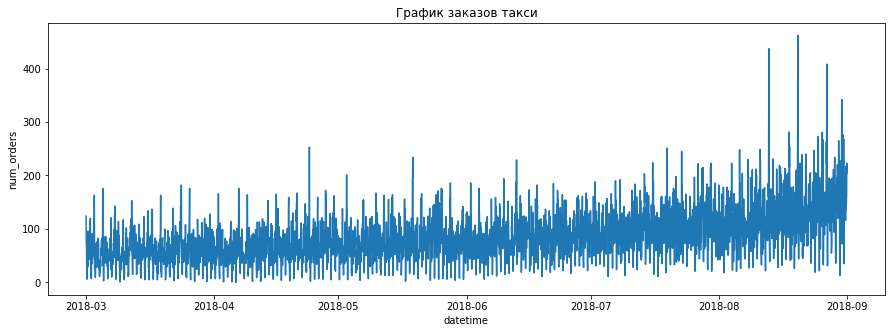

In [16]:
# Строим график
plt.figure(figsize=(15, 5))
sns.lineplot(data=taxi_df, y='num_orders', x=taxi_df.index)
plt.title('График заказов такси')

Разложим временной ряд на тренд и сезонную компоненту.

In [17]:
decomposed = seasonal_decompose(taxi_df)  # Делаем декомпозицию временного ряда

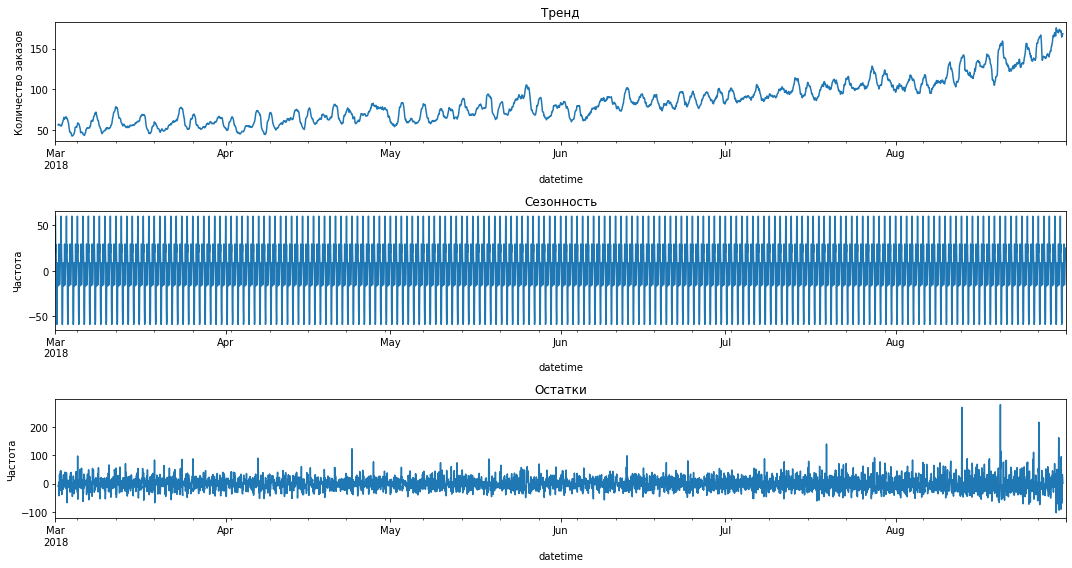

In [18]:
# Строим график
plt.figure(figsize=(15, 8))
plt.subplot(311)
decomposed.trend.plot(ax=plt.gca())
plt.ylabel('Количество заказов')
plt.title('Тренд')
plt.subplot(312)
decomposed.seasonal.plot(ax=plt.gca())
plt.title('Сезонность')
plt.ylabel('Частота')
plt.subplot(313)
decomposed.resid.plot(ax=plt.gca())
plt.title('Остатки')
plt.ylabel('Частота')
plt.tight_layout()

Тренд — ежемесячное увеличение количества заказов такси, так как растут продажи авиабилетов, а значит люди чаще летают. Сезонность связана с периодом меньше месяца, ее нужно исследовать боле тщательно. Остатки необъяснимы.

Построим график сезонности за две недели марта 2018 с 12 по 25

In [19]:
# Делаем ресемплирование по дню для двух недель
data_week = taxi_df['2018-03-12':'2018-03-25'].resample('1D').sum()

In [20]:
# Делаем декомпозицию временного ряда
decomposed = seasonal_decompose(data_week)

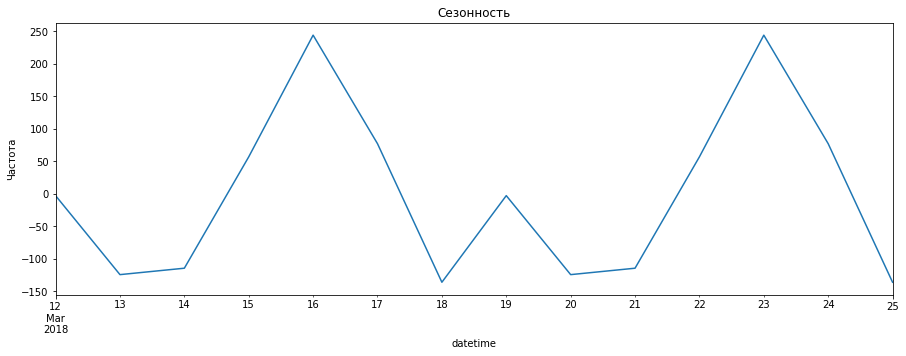

In [21]:
# Строим график
plt.figure(figsize=(15, 5))
decomposed.seasonal.plot()
plt.ylabel('Частота')
plt.title('Сезонность')

Количество заказов такси увеличивает с приближением выходных, а пик приходится на пятницу. Можно объяснить тем, что на выходные люди куда-нибудь улетают. А вот пн уже возвращаются, что как раз и показывает небольшой пик на графике.

Узнаем стационарный у нас ряд или нет. То есть найдем среднее и стандартное отклонение и если они не меняются, то у нас стационарный ряд.

In [22]:
# Делаем копию датасета
mean_std = taxi_df.copy()

In [23]:
# Находим СКО и среднее
mean_std['mean'] = mean_std['num_orders'].shift().rolling(15).mean()
mean_std['std'] = mean_std['num_orders'].shift().rolling(15).std()

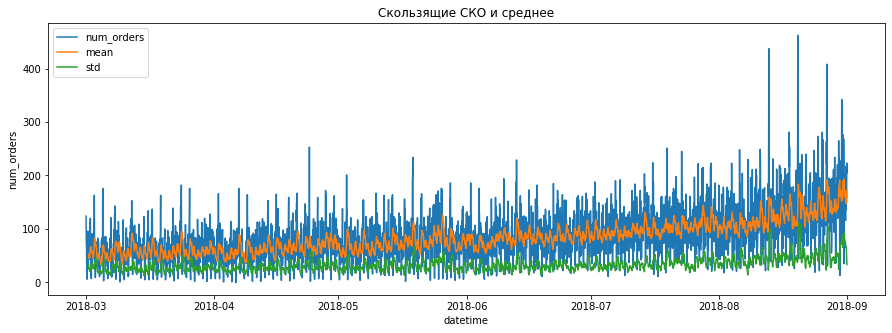

In [24]:
# Строим график
plt.figure(figsize=(15, 5))
sns.lineplot(data=mean_std, y='num_orders', x=mean_std.index)
sns.lineplot(data=mean_std, y='mean', x=mean_std.index)
sns.lineplot(data=mean_std, y='std', x=mean_std.index)
plt.legend(['num_orders', 'mean', 'std'])
plt.title('Скользящие СКО и среднее')

Хоть по графику и видно, что ряд нестационарный, так как меняется среднее значение, но убедимся в этом используя статистический тест Дики-Фуллера. Для этого выдвинем гипотезы:

- **H0** - Временной ряд является нестационарным.
- **H1** - Временной ряд является стационарным.

Предположим, что верна нулевая гипотеза, тогда

In [25]:
dickey_fuller(mean_std['num_orders'], ALPHA)

Не отвергаем H0. Временной ряд является нестационарным


С помощью статистического теста мы убедились, что ряд нестационарный.Но попробуем немного ослабить уровень значимости и примем его равным 5% и посмотрим какой получиться результат.

In [26]:
dickey_fuller(mean_std['num_orders'], 0.05)

Отвергаем H0 и принимаем H1. Временной ряд является стационарным


При уровне значимости равным 5% тест говорит, что у наш ряд является стационарным. Значит можно приступать к прогнозированию

### Вывод

На данном этапе провели анализ датафрейма и узнали, что у нас данные с марта по сентябрь 2018 года. Сделали декомпозицию ряда и выявили тренд — ежемесячное увеличение количества заказов такси. И сезонность — такси чаще заказывают, когда приближаются выходные и пик приходиться на пятницу. Можно объяснить тем, что на выходные люди куда-нибудь улетают. А вот понедельник уже возвращаются, что как раз и показывает небольшой пик на графике. Проверили временной ряд на стационарность при помощи статистического тест Дики-Фуллера. При уровне значимость 1%, тест говорит, что ряд нестационарный, но если его ослабить и взять уровень значимости 5%, то в таком случае тест говорит, что наш ряд стационарный. На этом уровне значимости и остановились. Теперь можно приступать к обучению моделей.

## Обучение

Приступим к обучению модели. Перед нами стоит задача регрессии, целевой признак `num_orders`. Оценивать результат будем по метрике RMSE, которая должна быть меньше < 48. Обучать будем 4 модели с подбором гипепараметров при помощи `RandomizedSearchCV`:
- `Ridge`
- `DecisionTreeRegressor`
- `KNeighborsRegressor`
- `LGBMRegressor`

Перед обучением создадим новые признаки для этого была написана функция `features_add` она принимает датафрейм и два числа, которые отвечают за размер отставания и за ширину окна для скользящего среднего.

In [28]:
# Создаем новые признаки
df_total = features_add(taxi_df, 8, 8)

In [29]:
# Разбиваем данные на выборки
train, test = train_test_split(df_total, shuffle=False, test_size=TEST_SIZE)

In [30]:
# Проверяем разбились ли данные корректно
print('Обучающая выборка:')
print(train.index.min(), train.index.max())
print('Тестовая выборка:')
print(test.index.min(), test.index.max())

Обучающая выборка:
2018-03-01 00:00:00 2018-08-13 13:00:00
Тестовая выборка:
2018-08-13 14:00:00 2018-08-31 23:00:00


Данные разбили правильно

In [31]:
# Удаляем пропуски
train = train.dropna()

In [32]:
# Отделяем таргет
X_train = train.drop(columns=['num_orders'], axis=1)
y_train = train['num_orders']
X_test = test.drop(columns=['num_orders'], axis=1)
y_test = test['num_orders']

In [33]:
# Создаем список для перебора моделей и их гиперпараметров
algs = [
    ['Ридж регрессия', Ridge(random_state=RANDOM_STATE), {
        'alpha': [0.1, 1, 10]}],
    ['Решающее дерево', DecisionTreeRegressor(random_state=RANDOM_STATE),
     {'min_samples_split': range(1, 7), 'min_samples_leaf': range(1, 7), 'max_depth': range(2, 7)}],
    ['К-ближайших соседа', KNeighborsRegressor(),
     {'n_neighbors': range(2, 40), 'algorithm': ['ball_tree', 'kd_tree']}],
    ['Градиентный бустинг', LGBMRegressor(random_state=RANDOM_STATE, verbosity=-1),
     {'num_leaves': range(31, 50), 'n_estimators': [100, 150], 'learning_rate': [0.01, 0.1, 1]}]
]

In [34]:
# Используем кросс-валидацию временный рядов
tss = TimeSeriesSplit(n_splits=5)

In [35]:
# Перебираем в цикле модели и гиперпараметры, обучаем их и выводим результат на тренировочной
best_model = []
for alg_name, model, parametrs, in tqdm(algs):
    rscv = RandomizedSearchCV(
        model, parametrs, cv=tss,
        scoring='neg_mean_squared_error', n_jobs=-1, random_state=RANDOM_STATE)
    rscv.fit(X_train, y_train)
    pred = rscv.predict(X_train)
    rmse = sqrt(mean_squared_error(y_train, pred))
    print(f'{alg_name}: RMSE: {rmse:.2f}')
    print(rscv.best_params_)
    best_model.append(rscv.best_estimator_)

  0%|          | 0/4 [00:00<?, ?it/s]

Ридж регрессия: RMSE: 31.22
{'alpha': 10}
Решающее дерево: RMSE: 23.57
{'min_samples_split': 4, 'min_samples_leaf': 2, 'max_depth': 6}
К-ближайших соседа: RMSE: 27.32
{'n_neighbors': 30, 'algorithm': 'ball_tree'}
Градиентный бустинг: RMSE: 13.85
{'num_leaves': 38, 'n_estimators': 100, 'learning_rate': 0.1}


### Проверка на адекватность

Проверим модели на адекватность. Новое значение прогнозируется предыдущим значением ряда.

In [36]:
print('Среднее количество заказов в час:', round(test['num_orders'].mean(), 2))

pred_previous = test['num_orders'].shift()
pred_previous.iloc[0] = train['num_orders'].iloc[-1]
print('RMSE:', round(sqrt(mean_squared_error(
    test['num_orders'], pred_previous)), 2))

Среднее количество заказов в час: 139.56
RMSE: 58.86


Все модели по итогу прошли проверку на адекватность. Сведем все результаты в таблицу.

|**Модель**| **RMSE** | **Прошла проверку на адекватность** | **Удовлетворяет условию заказчика** |
|:--- |:----:|:----:|:----:|
|**Ridge**| 31.22 | ✅ | ✅ | ✅ |
|**DecisionTreeRegressor**| 23.57 | ✅ | ✅ |
|**KNeighborsRegressor**| 27.32 | ✅ | ✅ |
|**LGBMRegressor**| 13.85 | ✅ | ✅ |

Все модели удовлетворяют условию заказчика. Выбираем из них самую лучшую `LGBMRegressor` и проверим ее результаты на тесте.

## Предсказание на тесте

Сделаем предсказания на тесте, используя нашу лучшую модель

In [37]:
# Делаем предсказания на тесте, используя лучшую модель и считаем rmse
predict = best_model[3].predict(X_test)
rmse = round(sqrt(mean_squared_error(y_test, predict)), 2)
print(rmse)

46.08


Получаем метрику RMSE - 46.08. Она соотвесвует условию заказчика. Построим график предсказния и правильных ответов.

In [38]:
# Cохраняем предсказания в тестовый датафрейм
test['predict'] = predict

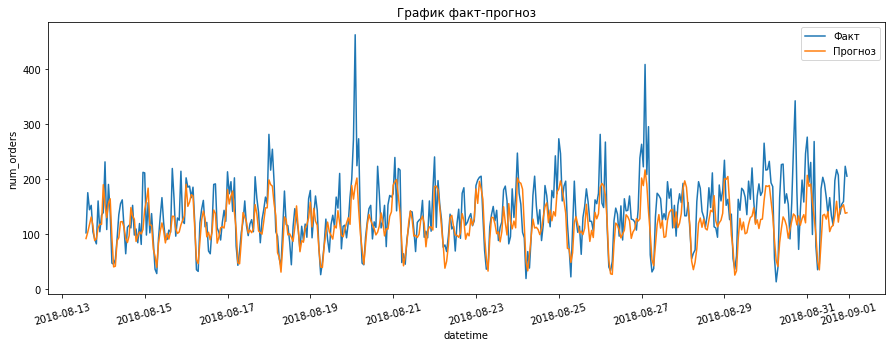

In [39]:
# Строим график
plt.figure(figsize=(15, 5))
sns.lineplot(data=test, y='num_orders', x=test.index)
sns.lineplot(data=test, y='predict', x=test.index)
plt.legend(['Факт', 'Прогноз'])
plt.xticks(rotation=15)
plt.title('График факт-прогноз')

По графику видно, что в целом модель работает хорошо, но модель не смогла уловить редкие пики (резкое увеличение заказов такси).

## Вывод

Данные лежат в файле `/datasets/taxi.csv`. Количество заказов находится в столбце `num_orders` (таргет).

План исследования:
1. Изучение данных 
2. Подготовка и предобработка данных
3. Анализ
4. Обучение
5. Тестирование
6. Вывод

**1. Изучение данных**

Данные, как и было сказано в документации находятся в `/datasets/taxi.csv`. У нас два столбца один используем в качестве индекса (столбец с датой) и второй столбец - наш таргет.  В таблице 1 столбец `int`(1). Количество строк 26496.

**2. Подготовка и предобработка данных**

Сначала отсортировали датафрейм по индексу. Далее по требованию заказчика сделали ресемплирование по одному часу. Проверили данные на пропущенные значения. По итогу их не обнаружили. Приступили к анализу.

**3. Анализ**

Провели анализ датафрейма и узнали, что у нас данные с марта по сентябрь 2018 года. Сделали декомпозицию ряда и выявили тренд — ежемесячное увеличение количества заказов такси. И сезонность — такси чаще заказывают, когда приближаются выходные и пик приходиться на пятницу. Можно объяснить тем, что на выходные люди куда-нибудь улетают. А вот пн уже возвращаются, что как раз и показывает небольшой пик на графике. Потом сделали наш ряд более стационарным, что позволило нам приступить к обучению. Проверили временной ряд на стационарность при помощи статистического тест Дики-Фуллера и написали функцию для этого `dickey_fuller`. При уровне значимость 1%, тест говорит, что ряд нестационарный, но если его ослабить и взять уровень значимости 5%, то в таком случае тест говорит, что наш ряд стационарный. На этом уровне значимости и остановились. Теперь можно приступать к обучению моделей.

**4. Обучение**

Перед нами стояла задача регрессии, целевой признак `num_orders`. Оценивали результат по метрике RMSE, которая должна быть меньше < 48 (по условию заказчика). Обучали будем 4 модели с подбором гипепараметров при помощи `RandomizedSearchCV`:
- `Ridge`
- `DecisionTreeRegressor`
- `KNeighborsRegressor`
- `LGBMRegressor`

Перед обучением создали новые признаки и для этого написали функцию `features_add` она принимает датафрейм и два числа, которые отвечают за размер отставания и за ширину окна для скользящего среднего. Создает 3 календарных признака (день, день недели и час), отстающие значения от 1 до числа, который отвечает за размер отставания и столбец со скользящим средним.Возвращала датафрейм с новыми признаками. Также при подборе гиперпараметров использовали кросс-валидацию для временных рядов `TimeSeriesSplit`. Проверили модели на адекватность. Прогнозировали новое значение предыдущим значением ряда. Свели все результаты в таблицу.

|**Модель**| **RMSE** | **Прошла проверку на адекватность** | **Удовлетворяет условию заказчика** |
|:--- |:----:|:----:|:----:|
|**Ridge**| 31.22 | ✅ | ✅ | ✅ |
|**DecisionTreeRegressor**| 23.57 | ✅ | ✅ |
|**KNeighborsRegressor**| 27.32 | ✅ | ✅ |
|**LGBMRegressor**| 13.85 | ✅ | ✅ |

Все модели удовлетворяют условию заказчика. Выбирали из них одну самую лучшую `LGBMRegressor` и проверили ее результаты на тесте.

**5. Тестирование**

Проверили нашу модель на тестовых данных. В результате получили метрику RMSE - 46.08. Она соотвесвует условию заказчика. А также построили график предсказния и правильных ответов. Модель работает хорошо с данными, но она не смогла уловить редкие пики (резкое увеличение заказов такси).

**Вывод**

По итогу была обучена модель, которая может предсказывать заказы такси на следующий час. Лучшая модель по итогу стала `LGBMRegressor` ее значение метрики 46.08 (удовлетворяет условиям заказчика). То есть она в среднем ошибается на 46 заказов. Данную модель думаю можно улучшить увеличив количество данных на которых можно обучиться. А также добавить больше данных о поездках.